<a href="https://colab.research.google.com/github/meetptl04/ImageStyleTranfer/blob/main/imgstyletransfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import time
import functools


In [ ]:
def load_and_process_img(path_to_img):
    max_dim = 512
    img = kp_image.load_img(path_to_img)
    img = kp_image.img_to_array(img)

    long = max(img.shape[:-1])
    scale = max_dim / long
    img = tf.image.resize(img,
                          (round(img.shape[0]*scale), round(img.shape[1]*scale)))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1',
                    'block3_conv1', 'block4_conv1',
                    'block5_conv1']

    content_output = [vgg.get_layer(layer).output for layer in content_layers]
    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]

    model_outputs = style_outputs + content_output

    model = Model(vgg.input, model_outputs)
    return model


In [ ]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))


In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(gram_style_features)]
    content_output_features = model_outputs[len(gram_style_features):]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(gram_style_features))
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(len(content_features))
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score


In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss


In [ ]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Extract feature representations
    content_features = model(content_image)[-1]
    style_features = model(style_image)[:-1]

    return style_features, content_features


In [ ]:
def run_style_transfer(content_path, style_path, num_iterations=1000,
                       content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    # Use a floating-point value for the learning rate
    opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

    iter_count = 1
    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % 100 == 0:
            print(f'Iteration: {i}, Total loss: {loss}, Style loss: {style_score}, Content loss: {content_score}')

    return best_img, best_loss


Iteration: 0, Total loss: 1129928704.0, Style loss: 1129928704.0, Content loss: 0.0
Iteration: 100, Total loss: 19054740.0, Style loss: 14888740.0, Content loss: 4166000.5
Iteration: 200, Total loss: 9265481.0, Style loss: 5629560.0, Content loss: 3635920.75
Iteration: 300, Total loss: 5595997.0, Style loss: 2705441.25, Content loss: 2890555.75
Iteration: 400, Total loss: 3948822.0, Style loss: 1617808.0, Content loss: 2331014.0
Iteration: 500, Total loss: 3089955.0, Style loss: 1136056.125, Content loss: 1953899.0
Iteration: 600, Total loss: 2577821.75, Style loss: 891556.625, Content loss: 1686265.125
Iteration: 700, Total loss: 2257387.25, Style loss: 756588.625, Content loss: 1500798.625
Iteration: 800, Total loss: 2042398.0, Style loss: 668025.5625, Content loss: 1374372.5
Iteration: 900, Total loss: 1883282.0, Style loss: 610502.9375, Content loss: 1272779.125


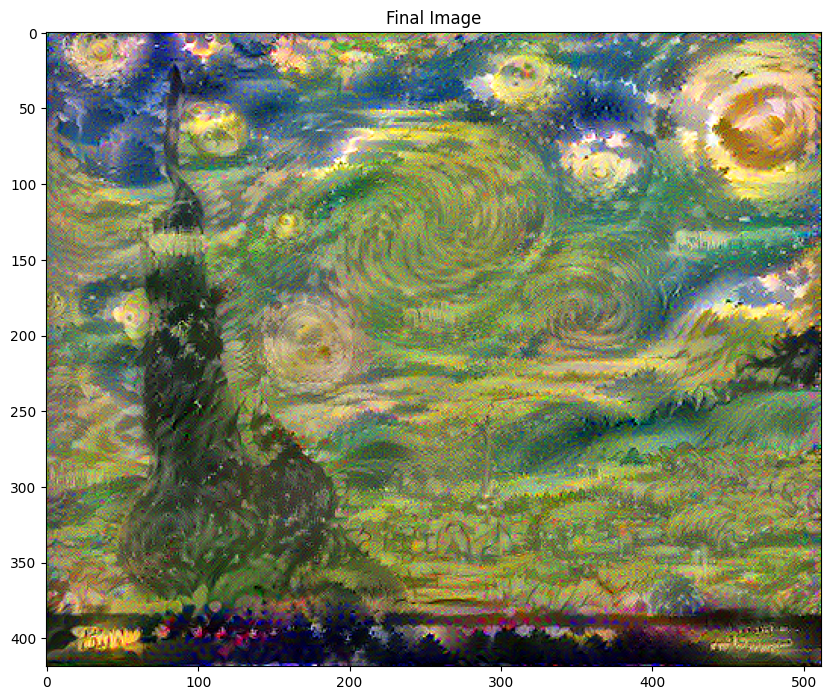

In [ ]:
def show_results(best_img):
    plt.figure(figsize=(10, 10))
    plt.imshow(best_img)
    plt.title('Final Image')
    plt.show()

# Load your content and style images
best_img, best_loss = run_style_transfer('/content/the-starry-night.jpg',
                                         '/content/Fantasy-Garden.png')

# Display the resulting image
show_results(best_img)
